In [28]:
# Load the usual culprits
import os, sys
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# Load some imports from dipy
from dipy.data import fetch_cenir_multib, read_cenir_multib, gradient_table
from dipy.segment.mask import median_otsu

# Modify the module path (if required) so that we can import
# modules from this repository
module_path = os.path.join(os.path.abspath(os.path.join('..')), 'pymods')
if module_path not in sys.path:
    sys.path.append(module_path)
from plotutils import plot_3d_z_indices

### Loading Example data from dipy

Since we cannot find publicly available single shell data, we use multishell data from data and transform it to look like single shell data

In [2]:
# This downloads only eddy-current/motion corrected data (a couple of GB will be downloaded)
fetch_cenir_multib(with_raw=False)
# Read just one shell of data for b-value = 1000
img, gtab = read_cenir_multib([1000])
data = img.get_data()

Creating new folder /home/sld0465/.dipy/cenir_multib
Download Progress: [##################################] 100.00%  of 53.31 MBDownloading "dwi_bvals_B200" to /home/sld0465/.dipy/cenir_multib
Download Progress: [##################################] 100.00%  of 0.00 MBDownloading "dwi_bvecs_B200" to /home/sld0465/.dipy/cenir_multib
Download Progress: [##################################] 100.00%  of 0.00 MBDownloading "4D_dwieddycor_B400.nii.gz" to /home/sld0465/.dipy/cenir_multib
Download Progress: [##################################] 100.00%  of 53.20 MBDownloading "bvals_B400" to /home/sld0465/.dipy/cenir_multib
Download Progress: [##################################] 100.00%  of 0.00 MBDownloading "bvecs_B400" to /home/sld0465/.dipy/cenir_multib
Download Progress: [##################################] 100.00%  of 0.00 MBDownloading "4D_dwieddycor_B1000.nii.gz" to /home/sld0465/.dipy/cenir_multib
Download Progress: [##################################] 100.00%  of 534.97 MBDownloading "

({'4D_dwi_eddycor_B200.nii.gz': ('https://digital.lib.washington.edu/researchworks/bitstream/handle/1773/33311/4D_dwi_eddycor_B200.nii.gz',
   'fd704aa3deb83c1c7229202cb3db8c48'),
  '4D_dwieddycor_B1000.nii.gz': ('https://digital.lib.washington.edu/researchworks/bitstream/handle/1773/33311/4D_dwieddycor_B1000.nii.gz',
   'dde8037601a14436b2173f4345b5fd17'),
  '4D_dwieddycor_B2000.nii.gz': ('https://digital.lib.washington.edu/researchworks/bitstream/handle/1773/33311/4D_dwieddycor_B2000.nii.gz',
   'c5e4b96e3afdee99c0e994eff3b2331a'),
  '4D_dwieddycor_B3000.nii.gz': ('https://digital.lib.washington.edu/researchworks/bitstream/handle/1773/33311/4D_dwieddycor_B3000.nii.gz',
   'f0d70456ce424fda2cecd48e64f3a151'),
  '4D_dwieddycor_B400.nii.gz': ('https://digital.lib.washington.edu/researchworks/bitstream/handle/1773/33311/4D_dwieddycor_B400.nii.gz',
   '3d0f2b8ef7b6a4a3aa5c4f7a90c9cfec'),
  'bvals_B1000': ('https://digital.lib.washington.edu/researchworks/bitstream/handle/1773/33311/bvals_

In [67]:
# Convert multishell data to look like single shell data

# Take an average of all the b0 values
avg_b0_data = data[:,:,:,gtab.b0s_mask].mean(axis=-1)[:,:,:, np.newaxis]
# Concatenate the b0 average with the non-b0 data
ss_data = np.concatenate((avg_b0_data, data[:,:,:, ~gtab.b0s_mask]), axis=-1)

# extract the relevant parts of the bvals and the bvecs
ss_bval = np.concatenate((np.array([0.]), gtab.bvals[~gtab.b0s_mask]))
ss_bvecs = np.concatenate( (np.array([0., 0., 0.])[np.newaxis, :], gtab.bvecs[~gtab.b0s_mask, :]))

# Now we have a single shell gradient table
ss_gtab = gradient_table(ss_bval, ss_bvecs, big_delta=gtab.big_delta, 
                         small_delta=gtab.small_delta, b0_threshold=gtab.b0_threshold)

### (Alternative) Loading single shell data from separate files 

This is the more common usecase

In [12]:
# # If the data is already single shell data in separate files
# # fdwi (filename of dwi file)
# # fbval (filename of bval file)
# # fbvec (filename of vec file)
# import nibabel as nib
# from dipy.io import read_bvals_bvecs
# from dipy.core.gradients import gradient_table

# img = nib.load(fdwi)
# data = img.get_data()
# bvals, bvecs = read_bvals_bvecs(fbval, fbvec)
# gtab = gradient_table(bvals, bvecs)

In [ ]:
#we remove the background of the image to avoid unnecessary calculations.
maskdata, mask = median_otsu(ss_data, 4, 2, False, vol_idx=[0], dilate=1)

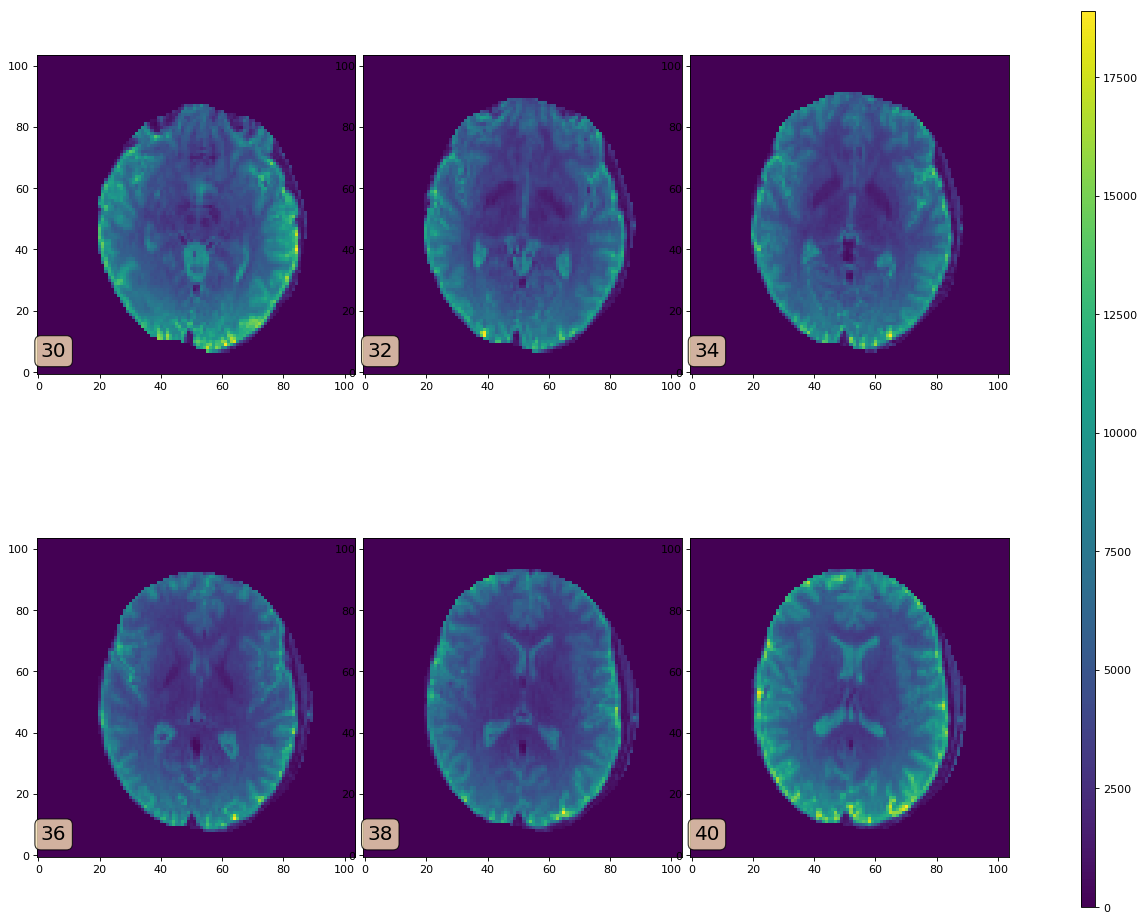

In [5]:
plot_3d_z_indices(maskdata[:,:,:,0], idx_list=range(30, 41, 2) , num_rows=2, num_cols=3)

In [4]:
smalldata = maskdata[30:70,30:70,30:41, :]
smalldata.shape

(40, 40, 11, 202)

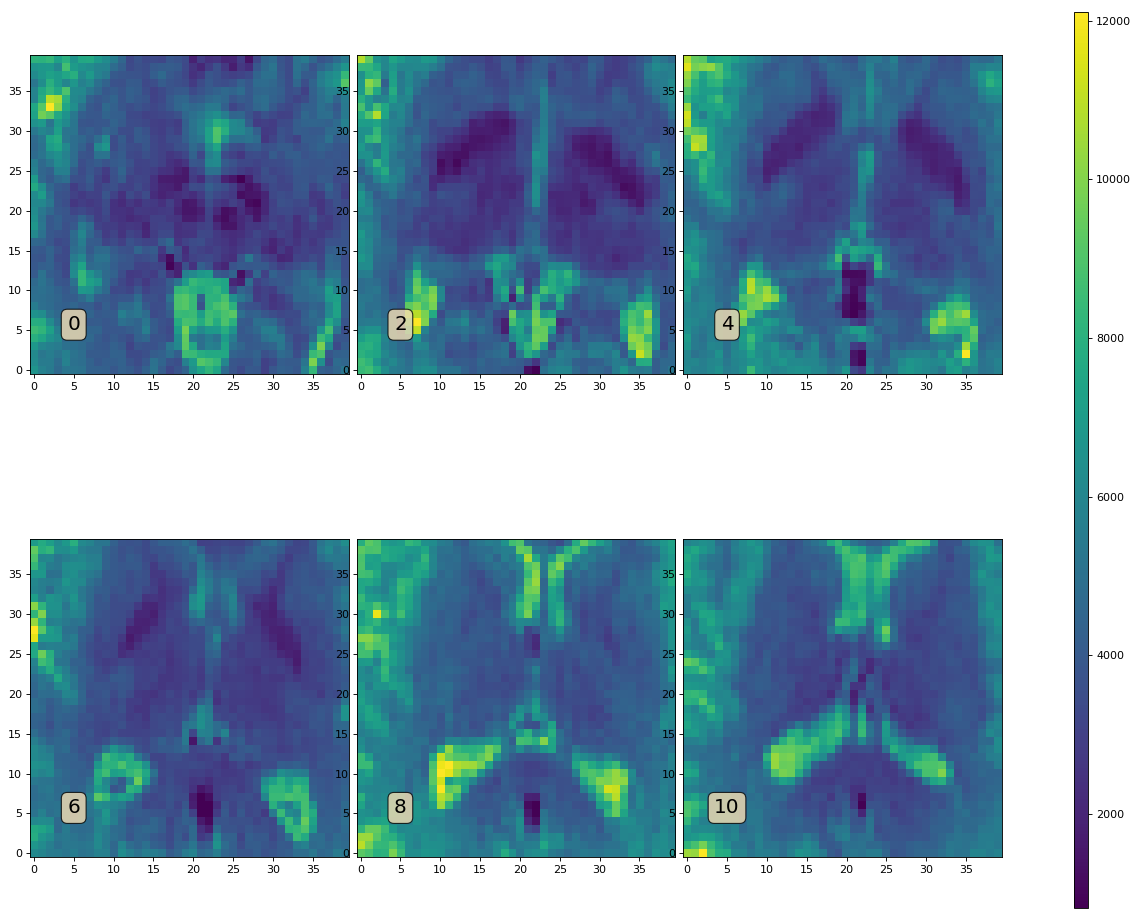

In [8]:
plot_3d_z_indices(smalldata[:,:,:,0], idx_list=range(0, 11, 2) , num_rows=2, num_cols=3)

# Now let us work with smalldata and get the freewater maps, FA, corrected-FA etc

In [10]:
from freewater import FreeWaterGradientDescent, create_feature_spatial_manifold
from freewater import convert_manifold_to_lower_tri_order
from tracer import LossTracer, IdxTracer

from dipy.reconst.vec_val_sum import vec_val_vect
from dipy.reconst.dti import decompose_tensor, from_lower_triangular
from dipy.reconst.dti import MIN_POSITIVE_SIGNAL
MIN_POSITIVE_EIGENVALUE = 1e-12

def log_transform_to_qform(evals, evecs):
    """Takes evals and evecs and returns a q-form that can be sent into free water calc"""
    evals_copy = evals.copy()
    evals_copy[evals_copy <= 0] = MIN_POSITIVE_EIGENVALUE
    qform = vec_val_vect(evecs, evals)
    return(qform)

def exp_transform_from_qform(qform):
    """Takes a q form and returns evals and evecs"""
    return (decompose_tensor(from_lower_triangular(qform), min_diffusivity=MIN_POSITIVE_EIGENVALUE))

class FreewaterRunner:
    """ This class interfaces with the class FreeWaterGradientDescent which actually 
        runs the gradient descent. Here we
          1. Prepare the data in form required by class FreeWaterGradientDescent
          2. Do the log-euclidean transform
          3. Do the reverse log-euclidean transform to get the data back in the manifold"""
    pass


